In [21]:
import gc 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from typing import Union, List

from multiprocessing import Pool

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


%pylab inline

Populating the interactive namespace from numpy and matplotlib


# My implementation of RandomForestClassifier 

In [2]:
class MyRandomForestClassifier:
    _base_model_class = DecisionTreeClassifier
    
    _default_base_model_params = {
        "criterion": 'gini', 
        "max_depth": None, 
        "min_samples_split": 2, 
        "min_samples_leaf": 1, 
        "min_weight_fraction_leaf": 0.0, 
        "max_features": 'auto', 
        "max_leaf_nodes": None, 
        "min_impurity_decrease": 0.0, 
        "min_impurity_split": None,
    }
    
    def __init__(
        self,
        n_estimators: int = 100,
        bootstrap: bool = True,
        random_state: Union[int, np.random.RandomState] = None,
        max_samples: int = None,
        base_model_params: dict = {},
        threads: int = None,
    ):
        self._n_estimators = n_estimators
        self._bootstrap = bootstrap
        self._random_state = random_state
        self._max_samples = max_samples
        self._base_model_params = {**self._default_base_model_params, **base_model_params}
        self._estimators: List[self._base_model_class] = []
        self._data: pd.DataFrame = None
        self._threads = threads
        
    def fit(self, x: pd.DataFrame, y: pd.Series):
        self._set_random_state()
        data = x.copy()
        data["target"] = y
        self._data = data
        if self._threads:
            with Pool(self._threads) as pool:
                self._estimators = pool.map(self._fit_one, range(self._n_estimators))
        else:
            self._estimators = [self._fit_one(i) for i in range(self._n_estimators)]
    
    def predict(self, x: pd.DataFrame) -> np.array:
        proba = self.predict_proba(x)
        predicted = proba.argmax(axis=1)
        return predicted
        
    
    def predict_proba(self, x: pd.DataFrame) -> np.ndarray:
        probas = self._predict_probas(x)
        proba = 0
        for predicted in probas:
            proba += predicted
        proba /= len(probas)
        return proba
    
    def _predict_probas(self, x: pd.DataFrame) -> list:
        if self._threads:
            with Pool(self._threads) as pool:
                probas = pool.starmap(
                    self._predict_one_proba, 
                    [(i, x) for i in range(self._n_estimators)]
                )
        else:
            probas = [clf.predict_proba(x) for clf in self._estimators]
        
        return probas
    
    def _predict_one_proba(self, i: int, x: pd.DataFrame) -> np.ndarray:
        return self._estimators[i].predict_proba(x)
                        
    def _set_random_state(self) -> None:
        if self._random_state is None:
            return
        if isinstance(self._random_state, int):
            np.random.seed(self._random_state)
        elif isinstance(self._random_state, np.random.RandomState):
            np.random.set_state(self._random_state)
        else:
            raise ValueError(f"Invalid random state type: {type(self._random_state)}")
    
    def _fit_one(self, i: int = None) -> _base_model_class:
        classifier = self._base_model_class(**self._base_model_params)
        data = self._get_samples(self._data)
        x = data.drop(columns="target")
        classifier.fit(x, data["target"])
        return classifier
        
    
    def _get_samples(self, data: pd.DataFrame) -> pd.DataFrame:
        if not self._bootstrap:
            return data
        max_sample = self._max_samples
        if max_sample is None:
            max_sample = data.shape[0]
        return data.sample(max_sample)

# Function to draw confusion matrix

In [34]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Read data

In [3]:
df = pd.read_csv("data/train.csv", index_col="id")
print("Shape:", df.shape)
df.head()

Shape: (957919, 119)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,-12.2280,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.1,1.01770,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,-56.7580,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.0,0.28359,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,-5.7688,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.2,0.40690,1
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,-34.8580,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.1,0.51486,1
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,-13.6410,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,NaN,0.23049,1


## Check NA

In [4]:
print("NA:")
pd.DataFrame(df.isna().sum())

NA:


,0
f1,15247
f2,15190
f3,15491
f4,15560
f5,15405
...,...
f115,15559
f116,15589
f117,15407
f118,15212


In [5]:
df.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,claim
count,942672.000000,942729.000000,942428.000000,942359.000000,942514.000000,942398.000000,942415.000000,9.425460e+05,9.426700e+05,942696.000000,...,942554.000000,942420.000000,942509.000000,942686.000000,942481.000000,942360.000000,9.423300e+05,942512.000000,942707.000000,957919.000000
mean,0.090201,0.345964,4068.744207,0.201214,0.304869,-0.071458,1620.843815,3.771642e+05,1.806054e+15,5323.442367,...,-19.926398,2.074530,23.885245,1.748777,63152.973540,1.208876,4.276905e+16,3959.204669,0.559267,0.498492
std,0.043564,0.146251,6415.829440,0.212510,0.145343,2.123777,1276.281403,3.454325e+05,2.335204e+15,10068.380032,...,18.578439,0.895793,45.581360,10.088848,92435.016241,0.114959,6.732441e+16,3155.991777,0.408426,0.499998
min,-0.149910,-0.019044,-9421.700000,-0.082122,-0.006990,-12.791000,-224.800000,-2.984300e+04,-1.153300e+15,-26404.000000,...,-105.860000,0.277040,-27.691000,-26.589000,-81977.000000,0.905270,-8.944400e+15,-415.240000,-0.151240,0.000000
25%,0.070227,0.283050,418.430000,0.035086,0.240520,-1.120700,481.545000,9.120900e+04,1.153100e+13,75.876750,...,-28.812000,1.487700,-0.628880,-4.473975,2443.200000,1.146800,2.321100e+14,1306.200000,0.276560,0.000000
50%,0.090135,0.389100,1279.500000,0.137000,0.327790,-0.380110,1446.100000,2.896700e+05,5.043050e+14,1073.200000,...,-14.636000,1.662100,1.727700,0.885710,19479.000000,1.177200,1.327500e+16,3228.000000,0.473440,0.000000
75%,0.116500,0.458450,4444.400000,0.297100,0.412830,0.921940,2495.900000,5.605600e+05,3.103100e+15,5693.200000,...,-5.325300,2.522325,18.991000,6.840775,88488.000000,1.242000,5.278700e+16,6137.900000,0.746210,1.000000
max,0.415170,0.518990,39544.000000,1.319900,0.554750,11.202000,5426.600000,1.913700e+06,1.042400e+16,85622.000000,...,1.613400,4.565900,217.840000,47.757000,526050.000000,1.886700,3.249900e+17,13151.000000,2.743600,1.000000


## Fill NA

In [6]:
df.fillna(df.mean(), inplace=True)
print("Shape:", df.shape)

y = df.claim
x = df.drop(columns="claim")

Shape: (957919, 119)


# Split train/test

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# Train my implementation

In [8]:
clf = MyRandomForestClassifier(n_estimators=20, threads=8)
clf.fit(X_train, y_train)

In [9]:
predicted = clf.predict(X_test)

In [18]:
accuracy_score(y_test, predicted)

0.5112491063350564

In [30]:
cf_matrix = confusion_matrix(y_test, predicted)

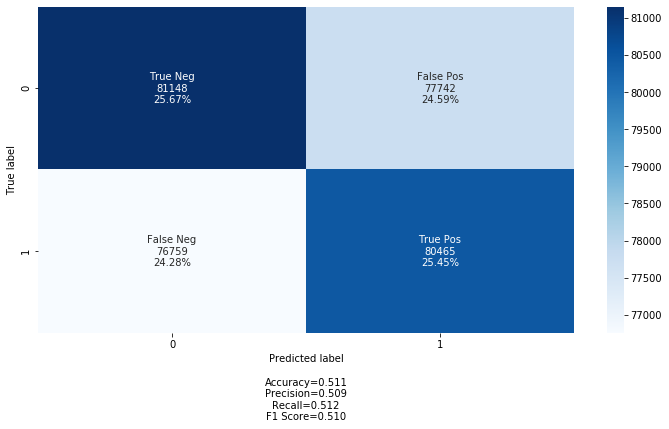

In [33]:
labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
make_confusion_matrix(cf_matrix, figsize=(12, 6), group_names=labels)